<a href="https://colab.research.google.com/github/jrodriguezshaw/mlprodobl/blob/testing/Copia_de_entrenamiento_obl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

#!pip install tensorflow-io
!pip install azure-storage-blob
#!pip install azure-storage-file-share
!pip install split-folders
!mkdir img
!mkdir dataset

#Imports
import os
import io
import matplotlib.pyplot as plt
import splitfolders
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from azure.storage.blob import BlobServiceClient, BlobClient
from PIL import Image



Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
mkdir: cannot create directory ‘img’: File exists
mkdir: cannot create directory ‘dataset’: File exists


In [3]:
# Test de ver otra forma de cargar  la info desde Azure
#import tensorflow as tf
#import tensorflow_io as tfio

# Alternatively, you can use a shared access signature (SAS) to authenticate with the Azure Storage Account
#os.environ['TF_AZURE_STORAGE_SAS'] = 'sp=r&st=2023-07-01T14:58:28Z&se=2023-07-31T22:58:28Z&spr=https&sv=2022-11-02&sr=c&sig=hMLDAdiKmWGNXUbM%2FFPMAyPh2LGAp4vPOdHfj1S%2BG1g%3D'
#account_name = 'azureworkspace5122300523'

# Datos de conexión

In [4]:
connection_string = "DefaultEndpointsProtocol=https;AccountName=azureworkspace5122300523;AccountKey=syBgKmFWZo1V5lTFRdP0M5RBEN//C715NzT3mIUkTIWF9slf2+GhBpyaS6R/DPaob3dfWfqtV0TH+ASttXbJMQ==;EndpointSuffix=core.windows.net"
container_name = "blob-storage"
blob_service_client = BlobServiceClient.from_connection_string(connection_string)

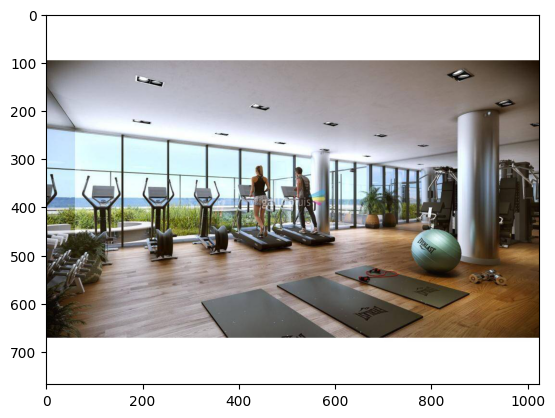

In [5]:
# Corroboramos que se pueda entrar en Azure
try:
    blob_name = 'full/Apartamento_15968017_15c40bb94e0f3ad419adc859f3d9293c55b82c59.jpg'
    blob_client = blob_service_client.get_blob_client(container_name, blob_name)
    stream = io.BytesIO()
    download_stream = blob_client.download_blob()
    stream.write(download_stream.readall())

    stream.seek(0)
    image = Image.open(stream)

    plt.imshow(image)
    plt.show()

except Exception as ex:
    print('Exception:')
    print(ex)

# Cargar localmente las imagenes del Blob de Azure

##Se tiene dos funciones:


1.   La primer revisa la carpeta de Azure y nos dice que cantidad  de elementos dentro de la carpeta
2.   La segunda se encarga de descargar las imagenes dentro de la carpeta de img

Obs: los path de las carpetas de img cambian segun donde se corra el notebook(Azure o Colab).


In [6]:
class Util:
  def length(self,folder):
    container_client =  blob_service_client.get_container_client(container_name)
    blobs_list = container_client.list_blobs(folder)
    my_list = list(blobs_list)
    print("Cantidad de elementos en la carpeta "+ folder+":")
    print(len(my_list))


In [7]:
# para borrar las carpetas en caso de que cambie el data set
#rm -r /content/img

In [ ]:
#LOCAL_BLOB_PATH = "Users/JR288624/Obl/img" # para Azure Jupyterlab
LOCAL_BLOB_PATH = "/content/img"
BLOBNAME="test"
class AzureBlobFileDownloader:
   def __init__(self):
        print("Intializing AzureBlobFileDownloader")
        self.blob_service_client = BlobServiceClient.from_connection_string(connection_string)
        self.my_container = self.blob_service_client.get_container_client(container_name)
   def save_blob(self, file_name, file_content):
            # Get full path to the file
        download_file_path = os.path.join(LOCAL_BLOB_PATH, file_name)
        os.makedirs(os.path.dirname(download_file_path), exist_ok=True)
        with open(download_file_path, "wb") as file:
            file.write(file_content)


   def download_all_blobs_in_container(self,folder):
        my_blobs = self.my_container.list_blobs(folder)
        cantidad=0
        for blob in my_blobs:
            #print(blob.name)
            cantidad=cantidad+1
            bytes = self.my_container.get_blob_client(blob).download_blob().readall()
            self.save_blob(blob.name, bytes)
        print("cantidad de elementos descargados:")
        print(cantidad)

util = Util()
azure_blob_file_downloader = AzureBlobFileDownloader()
util.length("Casa")
azure_blob_file_downloader.download_all_blobs_in_container("Casa")
util.length("Apartamento")
azure_blob_file_downloader.download_all_blobs_in_container("Apartamento")



Intializing AzureBlobFileDownloader
Cantidad de elementos en la carpeta Casa:
688
cantidad de elementos descargados:
688
Cantidad de elementos en la carpeta Apartamento:
655


# EAS

### Explicar el uso de split y porque las cantidadas

In [ ]:
#Para Azure Jupyterlab
#IMAGE_PATH='Users/JR288624/Obl/img'
#base_uri='Users/JR288624/Obl/dataset'
IMAGE_PATH='/content/img'
base_uri='/content/dataset'
print(IMAGE_PATH)
splitfolders.ratio(IMAGE_PATH, output=(base_uri), seed=1337, ratio=(.7, .15, .15))
print("split done!")


 ### Cargar y normalizar el conjunto de datos

 La clase ImageDataGenerator en Keras proporciona un conjunto de técnicas para escalar los valores de píxeles en nuestro dataset de imágenes antes del modelado.

In [ ]:
#data generator
datagen = ImageDataGenerator()
# Batch de 64
# load
train_ds = datagen.flow_from_directory(base_uri+'/train', class_mode='categorical', batch_size=64)
# load
val_ds = datagen.flow_from_directory(base_uri+'/val/', class_mode='categorical', batch_size=64)
# load
test_ds = datagen.flow_from_directory(base_uri+'/test/', class_mode='categorical', batch_size=64)

In [ ]:
#Vemos si hay scale
batch_trainX, batchTrain_y = train_ds.next()
batch_valX, batchval_y = val_ds.next()
batch_testX, batchtest_y = test_ds.next()
print('Batch train ,shape=%s,shapey=%s, min=%.3f, max=%.3f, mean=%.3f,std=%.3f' % (batch_trainX.shape,batchTrain_y.shape, batch_trainX.min(), batch_trainX.max(),batch_trainX.mean(),batch_trainX.std()))
print('Batch val shape=%s, min=%.3f, max=%.3f, mean=%.3f,std=%.3f' % (batch_valX.shape, batch_valX.min(), batch_valX.max(),batch_valX.mean(),batch_valX.std()))
print('Batch test shape=%s, min=%.3f, max=%.3f, mean=%.3f,std=%.3f' % (batch_testX.shape, batch_testX.min(), batch_testX.max(),batch_testX.mean(),batch_testX.std()))

Podemos notar que las fotos son 256*256  con 3 canales en batch de 64.
Tambien notamos que las desviacion estandar es muy parecida entre los distintos sets.

 ### Transform pattern

"Transform pattern" en el contexto de Machine Learning se refiere a la técnica de manipular y cambiar los datos de entrada antes de que sean utilizados por un modelo.

Estos cambios pueden ayudar a mejorar el rendimiento del modelo y a hacer que el modelo sea más robusto ante variaciones en los datos de entrada.

Las transformaciones se aplican típicamente durante la etapa de preprocesamiento de los datos y pueden implicar muchas técnicas diferentes, dependiendo del tipo de datos y del problema que se está tratando de resolver.

En el caso de las imágenes, los patrones de transformación comunes incluyen la normalización (donde se ajusta la escala de los valores de los píxeles), la rotación, el cambio de tamaño, el recorte, la inversión horizontal/vertical (flip), el cambio de color, el zoom, entre otros.

In [ ]:
# Define el preprocesamiento de la imagen
data_augmentation = Sequential([
    preprocessing.Rescaling(1./255),
    preprocessing.RandomRotation(0.15),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomTranslation(0.1, 0.1),
    preprocessing.RandomContrast(0.2),
    preprocessing.RandomCrop(64, 64)
 ])

# Definición del modelo

In [ ]:
def create_model(learning_rate, num_units, dropout_rate):
      data_augmentation,  # Agrega las capas de preprocesamiento al inicio del modelo
      model = tf.keras.models.Sequential()
      model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3))),
      model.add(tf.keras.layers.BatchNormalization()),
      model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')),
      model.add(tf.keras.layers.BatchNormalization()),
      model.add(tf.keras.layers.MaxPooling2D((2, 2))),
      model.add(tf.keras.layers.Dropout(dropout_rate)),

      model.add(tf.keras.layers.Conv2D(num_units, (3, 3), padding='same', activation='relu')),
      model.add(tf.keras.layers.BatchNormalization()),
      model.add(tf.keras.layers.Conv2D(num_units, (3, 3), padding='same', activation='relu')),
      model.add(tf.keras.layers.BatchNormalization()),
      model.add(tf.keras.layers.MaxPooling2D((2, 2))),
      model.add(tf.keras.layers.Dropout(dropout_rate)),

      model.add(tf.keras.layers.Flatten()),
      model.add(tf.keras.layers.Dense(num_units, activation='relu')),
      model.add(tf.keras.layers.BatchNormalization()),
      model.add(tf.keras.layers.Dropout(dropout_rate)),
      model.add(tf.keras.layers.Dense(2, activation='softmax'))

      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Compila y entrena el modelo
      model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

      return model


In [ ]:
# Define tu modelo J
def create_modelj(learning_rate, num_units, dropout_rate):

    data_augmentation,  # Agrega las capas de preprocesamiento al inicio del model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(num_units, activation='relu', input_shape=(256, 256, 3)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(num_units, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Compila y entrena el modelo
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
hyperparameters = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'num_units': [32, 64, 128],
    'dropout_rate': [0.2, 0.4, 0.6]
}

In [ ]:
class MyEstimator:
    def __init__(self, learning_rate, batch_size, num_units, dropout_rate):
        # Inicializa los hiperparámetros y otras variables necesarias
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_units = num_units
        self.dropout_rate = dropout_rate

    def fit(self, X, y):
        # Crea y entrena el modelo con los hiperparámetros dados
        model = create_model(self.learning_rate,  self.num_units, self.dropout_rate)
        history = model.fit(X, y, batch_size=self.batch_size, epochs=10, validation_data=(batch_valX, batchval_y))
        self.model = model

        # Calcula la métrica de evaluación deseada (por ejemplo, precisión en el conjunto de validación)
    def score(self, X, y):
        # Calcula la puntuación del modelo en función de los datos de entrada
        # Implementa aquí tu lógica para calcular la puntuación
        loss, accuracy = self.model.evaluate(X, y)
        return accuracy

      # val_accuracy = history.history['val_accuracy'][-1]
       # return val_accuracy

    def get_params(self, deep=True):
        # Return the estimator's parameters as a dictionary
        return {
            'learning_rate': self.learning_rate,
            'batch_size': self.batch_size,
            'num_units': self.num_units,
            'dropout_rate': self.dropout_rate
        }

    def set_params(self, **params):
        # Set the estimator's parameters from the input dictionary
        for param, value in params.items():
            setattr(self, param, value)
        return self

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
estimator = MyEstimator(learning_rate=0.001, batch_size=32, num_units=64, dropout_rate=0.2)
random_search = RandomizedSearchCV(estimator, param_distributions=hyperparameters, n_iter=7, cv=5)
random_search.fit(batch_trainX,  batchTrain_y)


In [ ]:
# Obtener los mejores hiperparámetros y el rendimiento asociado
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Mejores hiperparámetros encontrados:")
print(best_params)
print("Mejor puntuación de validación cruzada:")
print(best_score)

Mejores hiperparámetros encontrados:
{'num_units': 32, 'learning_rate': 0.1, 'dropout_rate': 0.2, 'batch_size': 64}
Mejor puntuación de validación cruzada:
0.5935897529125214


In [ ]:
from keras.backend import dropout
#ejecuto Modelo Mejor hiperparametros
num_units, learning_rate,dropout_rate, batch_size = best_params
model_out = create_model( 0.1, 32, 0.2) #learning_rate,  num_units, dropout_rate)
history = model_out.fit(batch_trainX,  batchTrain_y, batch_size=64, epochs=10, validation_data=(batch_valX, batchval_y))


Epoch 1/10
1/1 [==============================] - 21s 21s/step - loss: 0.9828 - accuracy: 0.5312 - val_loss: 13102912.0000 - val_accuracy: 0.5156
Epoch 2/10
1/1 [==============================] - 16s 16s/step - loss: 0.7316 - accuracy: 0.6250 - val_loss: 241391.5781 - val_accuracy: 0.5156
Epoch 3/10
1/1 [==============================] - 17s 17s/step - loss: 0.6285 - accuracy: 0.6250 - val_loss: 91111.9531 - val_accuracy: 0.4688
Epoch 4/10
1/1 [==============================] - 16s 16s/step - loss: 0.6445 - accuracy: 0.6094 - val_loss: 47449.6250 - val_accuracy: 0.4688
Epoch 5/10
1/1 [==============================] - 16s 16s/step - loss: 0.5367 - accuracy: 0.6719 - val_loss: 36223.6250 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 18s 18s/step - loss: 0.4618 - accuracy: 0.7344 - val_loss: 47003.9609 - val_accuracy: 0.5156
Epoch 7/10
1/1 [==============================] - 16s 16s/step - loss: 0.3758 - accuracy: 0.8281 - val_loss: 32988.5078 - val_accuracy: 0.

In [ ]:
#from keras.engine.training import model_serialization
#history1 = model.fit(batch_trainX, batchTrain_y, batch_size=128, epochs=20, validation_data=(batch_valX, batchval_y))


In [ ]:
model_out.summary()

Model: "sequential_256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_419 (Conv2D)         (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_522 (Ba  (None, 256, 256, 32)     128       
 tchNormalization)                                               
                                                                 
 conv2d_420 (Conv2D)         (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization_523 (Ba  (None, 256, 256, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_209 (MaxPooli  (None, 128, 128, 32)     0         
 ng2D)                                                           
                                                    

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


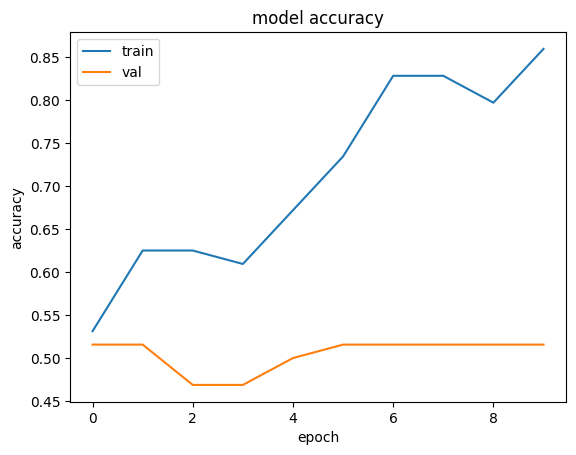

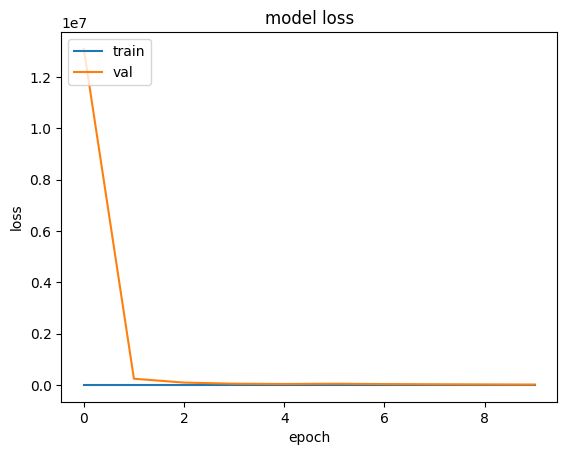

In [ ]:
print(history.history.keys())
# summarize history for accuracy durante el entrenamiento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss  durante el entrenamiento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# evaluate model
loss, acc = model_out.evaluate_generator(test_ds, steps=len(test_ds), verbose=0)
print('Test loss: %.3f' % (loss))
print('Test Accuracy: %.3f' % (acc))

<ipython-input-64-1bea51d00252>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model_out.evaluate_generator(test_ds, steps=len(test_ds), verbose=0)


Test loss: 13926.479
Test Accuracy: 0.512


In [ ]:
print(test_ds)